### Required Modules

In [ ]:
import numpy as np 
import pandas as pd
import h5py as h5
import seaborn as sns
import tensorflow as tf
import sys

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scripts.utils import train_keys

In [ ]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data 

In [ ]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl")

X_train, Y_train = train_data.iloc[:,:15].to_numpy(), train_data.iloc[:,-1].to_numpy()

validation_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl")

X_val, Y_val = validation_data.iloc[:,:15].to_numpy(), validation_data.iloc[:,-1].to_numpy()

In [4]:
print(X_train.shape)

(26715960, 15)


In [ ]:
# corr = X_train.corr()

<<<<<<< local
# plt.figure(figsize = (12,8))
# sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, linewidths = .5, cmap = "hot")
=======
#plt.figure(figsize = (12,8))
#sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, linewidths = .5, cmap = "hot")
>>>>>>> remote

In [ ]:
# standard scaler
scaler = StandardScaler()
scaler.fit(X_train)
x_train = scaler.transform(X_train)
x_val = scaler.transform (X_val)

###  Best Neural Network Classifier From Initial Grid Search

**Initial Grid Search Parameters**

Number of nodes: [5,10, 20, 30]

Number of layers: [2,3,4]

In [ ]:
file_path = '/share/rcifdata/jbarr/UKAEAGroupProject/grid_search/'
trainings = []
for i in range(336):
    trial_dict = pickle.load(open(file_path+"trial_"+str(i)+".pkl", 'rb'))
    trainings.append(trial_dict)

In [ ]:
### calculate the number of parameters
def model_params(nodes, n_inputs=15):
    nodes.append(1)
    params = 0
    
    # bottle neck, 0 if model doesn't include a bottle neck and 1 if the model does include one.
    bottle_in = 0
    bottle_hidden = 0
    
    # parameters from models
    for i in range(len(nodes)):
        if i == 0:
            if nodes[i] < n_inputs: bottle_in = 1
            params += n_inputs * nodes[i]
        else:
            params += nodes[i-1]* nodes[i]
            
            if nodes[i-1] < nodes[i]: bottle_hidden = 1
    
    # parameters from biases
    for i in nodes: 
        params += i
    return params, bottle_in, bottle_hidden

In [ ]:
assert model_params([2,2])[0] == 41

In [ ]:
# Find the best architecture
best_trial = None 
best_val_acc = - sys.float_info.max
val_accs = []
n_params = []
bottle_in = []
bottle_hid = []

for trial in trainings:
    val_acc = trial["perfomance"][1]
    
    val_accs.append(val_acc)
    
    n_param, bot_in, bot_hid  = model_params(list(trial['nodes']))
    
    n_params.append(n_param)
    
    bottle_in.append(bot_in)
    bottle_hid.append(bot_hid)
    
    
    
    if val_acc > best_val_acc: 
        best_val_acc = val_acc
        best_trial = trial
        
n_params = np.array(n_params)
bottle_in = np.array(bottle_in)
bottle_hid= np.array(bottle_hid)
val_accs = np.array(val_accs)


In [ ]:
print("Best Model\n")
print("Network:",best_trial["nodes"],"\n" )
print("Validation accuracy:", best_trial['perfomance'][1])

In [ ]:
plt.figure()
plt.plot(best_trial["history"]["acc"],color = 'blue')
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [ ]:
plt.figure()
plt.plot(best_trial["history"]["loss"], color = 'blue')
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("MSE")

In [ ]:
plt.figure()
plt.hist(val_accs, bins = 20, color = 'purple');
plt.xlabel("Validation Accuracy")
plt.ylabel("Frequency")

In [ ]:
plt.figure()
plt.plot(n_params[np.where(bottle_in == 0)], val_accs[np.where(bottle_in == 0)], '.', label = 'Normal')
plt.plot(n_params[np.where(bottle_in == 1)], val_accs[np.where(bottle_in == 1)], '.', label = 'Input bn')
plt.plot(n_params[np.where(bottle_hid == 1)], val_accs[np.where(bottle_hid == 1)], '.', label = 'Hidden bn')
plt.xlabel("Number of Model Parameters")
plt.ylabel("Validation Accuracy")
plt.legend()

<<<<<<< local <modified: text/plain>


>>>>>>> remote <removed>


### Grid Search Conclusion

Looking at the plot above we can see that increasing the number of model parameters in general leads to an increase in the models validation accuracy, the graph looks as though it will plateau, but it also suggestes we haven't hit the peak, a further grid search of models with a higher number of parameters should be conducted.

### Final classifier

In [ ]:
def nn_classifier():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation = 'tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(30, activation = 'tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(30, activation = 'tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(30, activation = 'tanh'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation = 'sigmoid')   
    ])
    return model

In [ ]:
model = nn_classifier()

<<<<<<< local <modified: >


2022-03-10 18:35:10.917435: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-10 18:35:10.918176: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-10 18:35:10.918331: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


>>>>>>> remote <removed>


In [ ]:
model.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics = 'acc')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)

In [ ]:
history = model.fit(x_train, Y_train, validation_data = (x_val, Y_val), batch_size = 4096, epochs =50, callbacks=[stop_early])

<<<<<<< local <modified: >


2022-03-10 18:35:33.798586: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-10 18:35:33.813404: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


>>>>>>> remote <removed>


Epoch 1/50
6523/6523 [==============================] - 347s 51ms/step - loss: 0.4837 - acc: 0.7460 - val_loss: 0.3819 - val_acc: 0.8157
Epoch 2/50
6523/6523 [==============================] - 275s 42ms/step - loss: 0.4049 - acc: 0.8011 - val_loss: 0.3720 - val_acc: 0.8217
Epoch 3/50
6523/6523 [==============================] - 252s 39ms/step - loss: 0.3969 - acc: 0.8060 - val_loss: 0.3682 - val_acc: 0.8240
Epoch 4/50
3928/6523 [=================>............] - ETA: 1:42 - loss: 0.3938 - acc: 0.8080

KeyboardInterrupt: 

In [ ]:
# !mkdir -p saved_model
# model.save('saved_model/classifier_model')

In [ ]:
plt.figure()
plt.plot(history.history['acc'], 'o', label = 'Train acc')
plt.plot(history.history['val_acc'], 'o', label = 'Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
plt.figure()
plt.plot(history.history['loss'], 'o', label = 'Train loss')
plt.plot(history.history['val_loss'], 'o', label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Evaluate Model on Test Set

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
!ls /share/rcifdata/jbarr/UKAEAGroupProject/data/

In [ ]:
test_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data_clipped.pkl")

X_test, Y_test = test_data.iloc[:,:15].to_numpy(), test_data.iloc[:,-1].to_numpy()

In [ ]:
x_test = scaler.transform(X_test)

In [ ]:
predictions = model.predict(x_test)

fpr, tpr, thresholds = roc_curve(Y_test, predictions)

In [ ]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(Y_test, predictions)

In [ ]:
plt.figure()
plt.plot(fpr, tpr)
random_class = np.arange(0,1,0.005)
plt.plot(random_class, random_class, '--')
plt.xlabel('False Positive Rate')
plt.ylabel('Flase Negative Rate')
plt.text(0.8, 0.2, f'auc = {auc: .2f}', fontsize=10)

In [ ]:
test_pred = np.where(predictions < 0.5, predictions, 1)
test_pred = np.where(predictions >= 0.5, test_pred, 0)

In [ ]:
n_positive = np.where(Y_test ==0)[0].shape[0]
n_negative = np.where(Y_test ==1)[0].shape[0]
div_arr = np.array([[n_positive, n_negative]]).T

In [ ]:
con_mat = confusion_matrix(Y_test, test_pred, labels =[0,1])/div_arr
sns.heatmap(con_mat, annot=True).set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual');

### Distributions from classifier

In [ ]:
preds = np.round(predictions).flatten()

In [ ]:
no_output = x_test[np.where(preds == 0)]
yes_output = x_test[np.where(preds == 1)] 
assert no_output.shape[0] + yes_output.shape[0] == x_test.shape[0]

In [ ]:
columns = list(train_data.iloc[:,:-1].columns)
print(columns)

In [ ]:
for i, column in enumerate(columns):
    # find the mean and std 
    mean_no, mean_yes = np.mean(no_output[:,i]), np.mean(yes_output[:,i])
    std_no, std_yes = np.std(no_output[:,i]), np.std(yes_output[:,i])
    
    no_lower, no_upper = (mean_no - 3*std_no), (mean_no + 3*std_no)
    yes_lower, yes_upper = (mean_yes - 3*std_yes), (mean_yes + 3*std_yes)
    
    plt.figure()
    plt.hist(no_output[:,i], histtype = 'step', color = 'lime',
             label =" No output", density = True, bins =50, range = (no_lower, no_upper));
    
    plt.hist(yes_output[:,i], histtype = 'step', color = 'purple',
             label = "Output", density = True, bins = 50, range = (yes_lower,yes_upper ));
    plt.legend()
    plt.xlabel(column)

# Train model with varying number of data points

In [12]:
def nn_classifier_big():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256,activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation = 'sigmoid')   
    ])
    return model

# def nn_classifier_big():
#     model = tf.keras.Sequential([
#     tf.keras.layers.Dense(30, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(30, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(30, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(1, activation = 'sigmoid')   
#     ])
#     return model

In [ ]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
# def nn_classifier_big():
#     model = tf.keras.Sequential([
#     tf.keras.layers.Dense(64, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(64, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(64, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(64, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(64, activation = 'relu'),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(1, activation = 'sigmoid')   
#     ])
#     return model
def nn_classifier_big():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(150, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(75, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation = 'sigmoid')   
    ])
    return model

In [ ]:
val_indices = np.random.choice(x_val.shape[0], size = 100_000, replace=False)
x_val_sample = x_val[val_indices]
y_val_sample = Y_val[val_indices]

In [ ]:
training_size = [1000, 2000, 5000,
                10_000, 12_500, 15_000, 20_000, 30_000, 50_000,
                 100_000, 200_000, 500_000,
                 1_000_000, x_train.shape[0]]
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

permuted_idx = np.random.permutation(x_train.shape[0])
permuted_x = x_train[permuted_idx]
permuted_y = Y_train[permuted_idx]

for size in training_size:

    x_sample = permuted_x[:size]
    y_sample = permuted_y[:size]
    
    batch_size = size if size <= 10_000 else 4096
    patience = 25 if size <= 10_000 else 5
    
    print(f"Training model with {size} training points:")
    model = nn_classifier_big()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'acc')
    stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = patience)
    history = model.fit(x_sample,
                        y_sample,
                        validation_data = (x_val_sample, y_val_sample),
                        batch_size = batch_size,
                        epochs = 100,
                        callbacks = [stop_early])

    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])
    
    print("\n \n")

Training model with 1000 training points:
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.6898 - acc: 0.5500 - val_loss: 0.6714 - val_acc: 0.6604
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.6667 - acc: 0.6660 - val_loss: 0.6564 - val_acc: 0.6604
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.6468 - acc: 0.6660 - val_loss: 0.6449 - val_acc: 0.6604
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.6440 - acc: 0.6660 - val_loss: 0.6338 - val_acc: 0.6604
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.6321 - acc: 0.6660 - val_loss: 0.6214 - val_acc: 0.6604
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.6154 - acc: 0.6660 - val_loss: 0.6111 - val_acc: 0.6604
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 0.6013 - acc: 0.6660 - val_loss: 0.6029 - val_acc: 0.6604
Epoch 8/100
1/1 [==============================] - 2s 2s/step 

1/1 [==============================] - 2s 2s/step - loss: 0.4351 - acc: 0.7910 - val_loss: 0.5988 - val_acc: 0.6919
Epoch 65/100
1/1 [==============================] - 2s 2s/step - loss: 0.4274 - acc: 0.7750 - val_loss: 0.6013 - val_acc: 0.6942
Epoch 66/100
1/1 [==============================] - 2s 2s/step - loss: 0.4331 - acc: 0.7860 - val_loss: 0.6086 - val_acc: 0.6955
Epoch 67/100
1/1 [==============================] - 2s 2s/step - loss: 0.4428 - acc: 0.7890 - val_loss: 0.6132 - val_acc: 0.6944
Epoch 68/100
1/1 [==============================] - 2s 2s/step - loss: 0.4277 - acc: 0.7820 - val_loss: 0.6179 - val_acc: 0.6916
Epoch 69/100
1/1 [==============================] - 2s 2s/step - loss: 0.4094 - acc: 0.8040 - val_loss: 0.6266 - val_acc: 0.6906
Epoch 70/100
1/1 [==============================] - 2s 2s/step - loss: 0.4147 - acc: 0.8120 - val_loss: 0.6342 - val_acc: 0.6941
Epoch 71/100
1/1 [==============================] - 2s 2s/step - loss: 0.4111 - acc: 0.7940 - val_loss: 0.6409

1/1 [==============================] - 2s 2s/step - loss: 0.5482 - acc: 0.6795 - val_loss: 0.5722 - val_acc: 0.6719
Epoch 28/100
1/1 [==============================] - 2s 2s/step - loss: 0.5438 - acc: 0.6880 - val_loss: 0.5708 - val_acc: 0.6730
Epoch 29/100
1/1 [==============================] - 2s 2s/step - loss: 0.5411 - acc: 0.6905 - val_loss: 0.5708 - val_acc: 0.6727
Epoch 30/100
1/1 [==============================] - 2s 2s/step - loss: 0.5426 - acc: 0.6845 - val_loss: 0.5715 - val_acc: 0.6733
Epoch 31/100
1/1 [==============================] - 2s 2s/step - loss: 0.5423 - acc: 0.6920 - val_loss: 0.5710 - val_acc: 0.6726
Epoch 32/100
1/1 [==============================] - 2s 2s/step - loss: 0.5404 - acc: 0.6980 - val_loss: 0.5701 - val_acc: 0.6734
Epoch 33/100
1/1 [==============================] - 2s 2s/step - loss: 0.5404 - acc: 0.6935 - val_loss: 0.5687 - val_acc: 0.6738
Epoch 34/100
1/1 [==============================] - 2s 2s/step - loss: 0.5320 - acc: 0.7025 - val_loss: 0.5686

1/1 [==============================] - 2s 2s/step - loss: 0.4439 - acc: 0.7825 - val_loss: 0.5632 - val_acc: 0.7195
Epoch 91/100
1/1 [==============================] - 2s 2s/step - loss: 0.4441 - acc: 0.7840 - val_loss: 0.5612 - val_acc: 0.7186
Epoch 92/100
1/1 [==============================] - 2s 2s/step - loss: 0.4426 - acc: 0.7820 - val_loss: 0.5656 - val_acc: 0.7187
Epoch 93/100
1/1 [==============================] - 2s 2s/step - loss: 0.4413 - acc: 0.7760 - val_loss: 0.5735 - val_acc: 0.7196
Epoch 94/100
1/1 [==============================] - 2s 2s/step - loss: 0.4382 - acc: 0.7885 - val_loss: 0.5735 - val_acc: 0.7200
Epoch 95/100
1/1 [==============================] - 2s 2s/step - loss: 0.4364 - acc: 0.7845 - val_loss: 0.5713 - val_acc: 0.7192
Epoch 96/100
1/1 [==============================] - 2s 2s/step - loss: 0.4280 - acc: 0.7920 - val_loss: 0.5733 - val_acc: 0.7171
Epoch 97/100
1/1 [==============================] - 2s 2s/step - loss: 0.4296 - acc: 0.7975 - val_loss: 0.5764

1/1 [==============================] - 2s 2s/step - loss: 0.5076 - acc: 0.7226 - val_loss: 0.5313 - val_acc: 0.7144
Epoch 54/100
1/1 [==============================] - 2s 2s/step - loss: 0.5128 - acc: 0.7252 - val_loss: 0.5320 - val_acc: 0.7150
Epoch 55/100
1/1 [==============================] - 2s 2s/step - loss: 0.5096 - acc: 0.7260 - val_loss: 0.5322 - val_acc: 0.7159
Epoch 56/100
1/1 [==============================] - 2s 2s/step - loss: 0.5030 - acc: 0.7270 - val_loss: 0.5315 - val_acc: 0.7140
Epoch 57/100
1/1 [==============================] - 2s 2s/step - loss: 0.5085 - acc: 0.7284 - val_loss: 0.5313 - val_acc: 0.7148
Epoch 58/100
1/1 [==============================] - 2s 2s/step - loss: 0.5069 - acc: 0.7294 - val_loss: 0.5316 - val_acc: 0.7171
Epoch 59/100
1/1 [==============================] - 2s 2s/step - loss: 0.5073 - acc: 0.7344 - val_loss: 0.5299 - val_acc: 0.7186
Epoch 60/100
1/1 [==============================] - 2s 2s/step - loss: 0.5036 - acc: 0.7310 - val_loss: 0.5273

1/1 [==============================] - 2s 2s/step - loss: 0.5703 - acc: 0.6696 - val_loss: 0.5701 - val_acc: 0.6641
Epoch 17/100
1/1 [==============================] - 2s 2s/step - loss: 0.5704 - acc: 0.6727 - val_loss: 0.5677 - val_acc: 0.6644
Epoch 18/100
1/1 [==============================] - 2s 2s/step - loss: 0.5677 - acc: 0.6747 - val_loss: 0.5659 - val_acc: 0.6659
Epoch 19/100
1/1 [==============================] - 2s 2s/step - loss: 0.5642 - acc: 0.6720 - val_loss: 0.5650 - val_acc: 0.6683
Epoch 20/100
1/1 [==============================] - 2s 2s/step - loss: 0.5615 - acc: 0.6769 - val_loss: 0.5642 - val_acc: 0.6723
Epoch 21/100
1/1 [==============================] - 2s 2s/step - loss: 0.5625 - acc: 0.6801 - val_loss: 0.5619 - val_acc: 0.6764
Epoch 22/100
1/1 [==============================] - 2s 2s/step - loss: 0.5592 - acc: 0.6820 - val_loss: 0.5602 - val_acc: 0.6761
Epoch 23/100
1/1 [==============================] - 2s 2s/step - loss: 0.5569 - acc: 0.6807 - val_loss: 0.5595

1/1 [==============================] - 2s 2s/step - loss: 0.4859 - acc: 0.7460 - val_loss: 0.5012 - val_acc: 0.7348
Epoch 80/100
1/1 [==============================] - 2s 2s/step - loss: 0.4885 - acc: 0.7443 - val_loss: 0.4983 - val_acc: 0.7378
Epoch 81/100
1/1 [==============================] - 2s 2s/step - loss: 0.4869 - acc: 0.7462 - val_loss: 0.4979 - val_acc: 0.7382
Epoch 82/100
1/1 [==============================] - 2s 2s/step - loss: 0.4850 - acc: 0.7505 - val_loss: 0.5002 - val_acc: 0.7371
Epoch 83/100
1/1 [==============================] - 2s 2s/step - loss: 0.4839 - acc: 0.7540 - val_loss: 0.5003 - val_acc: 0.7375
Epoch 84/100
1/1 [==============================] - 2s 2s/step - loss: 0.4874 - acc: 0.7505 - val_loss: 0.4962 - val_acc: 0.7396
Epoch 85/100
1/1 [==============================] - 2s 2s/step - loss: 0.4811 - acc: 0.7532 - val_loss: 0.4954 - val_acc: 0.7402
Epoch 86/100
1/1 [==============================] - 2s 2s/step - loss: 0.4815 - acc: 0.7495 - val_loss: 0.4968

4/4 [==============================] - 3s 770ms/step - loss: 0.4992 - acc: 0.7391 - val_loss: 0.5002 - val_acc: 0.7373
Epoch 42/100
4/4 [==============================] - 3s 768ms/step - loss: 0.4986 - acc: 0.7375 - val_loss: 0.4990 - val_acc: 0.7358
Epoch 43/100
4/4 [==============================] - 3s 763ms/step - loss: 0.4942 - acc: 0.7414 - val_loss: 0.4968 - val_acc: 0.7381
Epoch 44/100
4/4 [==============================] - 3s 776ms/step - loss: 0.4971 - acc: 0.7375 - val_loss: 0.4954 - val_acc: 0.7426
Epoch 45/100
4/4 [==============================] - 3s 767ms/step - loss: 0.4905 - acc: 0.7456 - val_loss: 0.4964 - val_acc: 0.7397
Epoch 46/100
4/4 [==============================] - 3s 761ms/step - loss: 0.4972 - acc: 0.7404 - val_loss: 0.4951 - val_acc: 0.7416
Epoch 47/100
4/4 [==============================] - 3s 800ms/step - loss: 0.4909 - acc: 0.7447 - val_loss: 0.4974 - val_acc: 0.7424
Epoch 48/100
4/4 [==============================] - 3s 766ms/step - loss: 0.4967 - acc: 0

Epoch 8/100
4/4 [==============================] - 3s 832ms/step - loss: 0.5591 - acc: 0.6825 - val_loss: 0.5550 - val_acc: 0.6774
Epoch 9/100
4/4 [==============================] - 3s 821ms/step - loss: 0.5521 - acc: 0.6868 - val_loss: 0.5476 - val_acc: 0.6878
Epoch 10/100
4/4 [==============================] - 3s 834ms/step - loss: 0.5497 - acc: 0.6913 - val_loss: 0.5438 - val_acc: 0.6928
Epoch 11/100
4/4 [==============================] - 3s 835ms/step - loss: 0.5391 - acc: 0.7067 - val_loss: 0.5396 - val_acc: 0.6965
Epoch 12/100
4/4 [==============================] - 3s 835ms/step - loss: 0.5451 - acc: 0.6979 - val_loss: 0.5377 - val_acc: 0.7037
Epoch 13/100
4/4 [==============================] - 3s 835ms/step - loss: 0.5347 - acc: 0.7093 - val_loss: 0.5316 - val_acc: 0.7092
Epoch 14/100
4/4 [==============================] - 3s 826ms/step - loss: 0.5313 - acc: 0.7097 - val_loss: 0.5279 - val_acc: 0.7114
Epoch 15/100
4/4 [==============================] - 3s 841ms/step - loss: 0.52

4/4 [==============================] - 3s 831ms/step - loss: 0.4174 - acc: 0.7930 - val_loss: 0.4435 - val_acc: 0.7752
Epoch 71/100
4/4 [==============================] - 3s 820ms/step - loss: 0.4173 - acc: 0.7883 - val_loss: 0.4462 - val_acc: 0.7745
Epoch 72/100
4/4 [==============================] - 3s 831ms/step - loss: 0.4151 - acc: 0.7935 - val_loss: 0.4462 - val_acc: 0.7744
Epoch 73/100
4/4 [==============================] - 3s 827ms/step - loss: 0.4110 - acc: 0.7947 - val_loss: 0.4432 - val_acc: 0.7769
Epoch 74/100
4/4 [==============================] - 3s 833ms/step - loss: 0.4123 - acc: 0.7938 - val_loss: 0.4416 - val_acc: 0.7765
Epoch 75/100
4/4 [==============================] - 3s 830ms/step - loss: 0.4110 - acc: 0.7941 - val_loss: 0.4422 - val_acc: 0.7776
Epoch 76/100
4/4 [==============================] - 3s 831ms/step - loss: 0.4076 - acc: 0.7981 - val_loss: 0.4444 - val_acc: 0.7773
Epoch 77/100
4/4 [==============================] - 3s 834ms/step - loss: 0.4057 - acc: 0

Epoch 32/100
5/5 [==============================] - 3s 721ms/step - loss: 0.4652 - acc: 0.7612 - val_loss: 0.4662 - val_acc: 0.7575
Epoch 33/100
5/5 [==============================] - 3s 728ms/step - loss: 0.4649 - acc: 0.7536 - val_loss: 0.4651 - val_acc: 0.7582
Epoch 34/100
5/5 [==============================] - 3s 722ms/step - loss: 0.4612 - acc: 0.7623 - val_loss: 0.4642 - val_acc: 0.7581
Epoch 35/100
5/5 [==============================] - 3s 722ms/step - loss: 0.4579 - acc: 0.7604 - val_loss: 0.4608 - val_acc: 0.7594
Epoch 36/100
5/5 [==============================] - 3s 709ms/step - loss: 0.4565 - acc: 0.7625 - val_loss: 0.4613 - val_acc: 0.7605
Epoch 37/100
5/5 [==============================] - 3s 724ms/step - loss: 0.4572 - acc: 0.7628 - val_loss: 0.4595 - val_acc: 0.7632
Epoch 38/100
5/5 [==============================] - 3s 724ms/step - loss: 0.4532 - acc: 0.7646 - val_loss: 0.4607 - val_acc: 0.7613
Epoch 39/100
5/5 [==============================] - 3s 723ms/step - loss: 0.

5/5 [==============================] - 3s 716ms/step - loss: 0.3695 - acc: 0.8206 - val_loss: 0.4126 - val_acc: 0.8000
Epoch 95/100
5/5 [==============================] - 3s 728ms/step - loss: 0.3658 - acc: 0.8186 - val_loss: 0.4119 - val_acc: 0.7966
Epoch 96/100
5/5 [==============================] - 3s 716ms/step - loss: 0.3676 - acc: 0.8204 - val_loss: 0.4105 - val_acc: 0.8005
Epoch 97/100
5/5 [==============================] - 3s 745ms/step - loss: 0.3668 - acc: 0.8225 - val_loss: 0.4091 - val_acc: 0.7986
Epoch 98/100
5/5 [==============================] - 3s 726ms/step - loss: 0.3579 - acc: 0.8286 - val_loss: 0.4118 - val_acc: 0.7992
Epoch 99/100
5/5 [==============================] - 3s 722ms/step - loss: 0.3630 - acc: 0.8255 - val_loss: 0.4127 - val_acc: 0.8005
Epoch 100/100
5/5 [==============================] - 3s 720ms/step - loss: 0.3631 - acc: 0.8242 - val_loss: 0.4157 - val_acc: 0.7948

 

Training model with 30000 training points:
Epoch 1/100
8/8 [========================

13/13 [==============================] - 6s 448ms/step - loss: 0.5491 - acc: 0.6932 - val_loss: 0.5323 - val_acc: 0.7045
Epoch 5/100
13/13 [==============================] - 6s 440ms/step - loss: 0.5364 - acc: 0.7076 - val_loss: 0.5213 - val_acc: 0.7159
Epoch 6/100
13/13 [==============================] - 6s 444ms/step - loss: 0.5224 - acc: 0.7192 - val_loss: 0.5088 - val_acc: 0.7281
Epoch 7/100
13/13 [==============================] - 6s 435ms/step - loss: 0.5136 - acc: 0.7262 - val_loss: 0.4995 - val_acc: 0.7366
Epoch 8/100
13/13 [==============================] - 6s 439ms/step - loss: 0.5062 - acc: 0.7318 - val_loss: 0.4924 - val_acc: 0.7418
Epoch 9/100
13/13 [==============================] - 6s 438ms/step - loss: 0.4979 - acc: 0.7376 - val_loss: 0.4838 - val_acc: 0.7477
Epoch 10/100
13/13 [==============================] - 6s 439ms/step - loss: 0.4922 - acc: 0.7419 - val_loss: 0.4798 - val_acc: 0.7517
Epoch 11/100
13/13 [==============================] - 6s 439ms/step - loss: 0.48

Epoch 10/100
25/25 [==============================] - 10s 387ms/step - loss: 0.4578 - acc: 0.7624 - val_loss: 0.4359 - val_acc: 0.7780
Epoch 11/100
25/25 [==============================] - 10s 387ms/step - loss: 0.4495 - acc: 0.7672 - val_loss: 0.4296 - val_acc: 0.7834
Epoch 12/100
25/25 [==============================] - 10s 387ms/step - loss: 0.4419 - acc: 0.7717 - val_loss: 0.4245 - val_acc: 0.7883
Epoch 13/100
25/25 [==============================] - 10s 388ms/step - loss: 0.4352 - acc: 0.7798 - val_loss: 0.4183 - val_acc: 0.7912
Epoch 14/100
25/25 [==============================] - 10s 386ms/step - loss: 0.4333 - acc: 0.7796 - val_loss: 0.4128 - val_acc: 0.7959
Epoch 15/100
25/25 [==============================] - 10s 384ms/step - loss: 0.4272 - acc: 0.7834 - val_loss: 0.4087 - val_acc: 0.8000
Epoch 16/100
25/25 [==============================] - 10s 385ms/step - loss: 0.4236 - acc: 0.7868 - val_loss: 0.4014 - val_acc: 0.8043
Epoch 17/100
25/25 [==============================] - 1

49/49 [==============================] - 18s 358ms/step - loss: 0.3662 - acc: 0.8234 - val_loss: 0.3516 - val_acc: 0.8300
Epoch 24/100
49/49 [==============================] - 17s 357ms/step - loss: 0.3616 - acc: 0.8261 - val_loss: 0.3505 - val_acc: 0.8321
Epoch 25/100
49/49 [==============================] - 18s 359ms/step - loss: 0.3610 - acc: 0.8266 - val_loss: 0.3497 - val_acc: 0.8321
Epoch 26/100
49/49 [==============================] - 18s 359ms/step - loss: 0.3604 - acc: 0.8267 - val_loss: 0.3504 - val_acc: 0.8312
Epoch 27/100
49/49 [==============================] - 18s 361ms/step - loss: 0.3607 - acc: 0.8255 - val_loss: 0.3481 - val_acc: 0.8324
Epoch 28/100
49/49 [==============================] - 17s 356ms/step - loss: 0.3564 - acc: 0.8277 - val_loss: 0.3458 - val_acc: 0.8338
Epoch 29/100
49/49 [==============================] - 17s 351ms/step - loss: 0.3566 - acc: 0.8280 - val_loss: 0.3452 - val_acc: 0.8345
Epoch 30/100
49/49 [==============================] - 18s 358ms/step

123/123 [==============================] - 41s 337ms/step - loss: 0.3418 - acc: 0.8357 - val_loss: 0.3284 - val_acc: 0.8414
Epoch 35/100
123/123 [==============================] - 41s 336ms/step - loss: 0.3399 - acc: 0.8373 - val_loss: 0.3302 - val_acc: 0.8408
Epoch 36/100
123/123 [==============================] - 41s 335ms/step - loss: 0.3388 - acc: 0.8373 - val_loss: 0.3281 - val_acc: 0.8413
Epoch 37/100
123/123 [==============================] - 41s 337ms/step - loss: 0.3387 - acc: 0.8373 - val_loss: 0.3304 - val_acc: 0.8400
Epoch 38/100
123/123 [==============================] - 41s 336ms/step - loss: 0.3402 - acc: 0.8364 - val_loss: 0.3288 - val_acc: 0.8415

 

Training model with 1000000 training points:
Epoch 1/100
245/245 [==============================] - 83s 332ms/step - loss: 0.5535 - acc: 0.6965 - val_loss: 0.4415 - val_acc: 0.7736
Epoch 2/100
245/245 [==============================] - 80s 327ms/step - loss: 0.4465 - acc: 0.7712 - val_loss: 0.3834 - val_acc: 0.8121
Epoch 3

KeyboardInterrupt: 

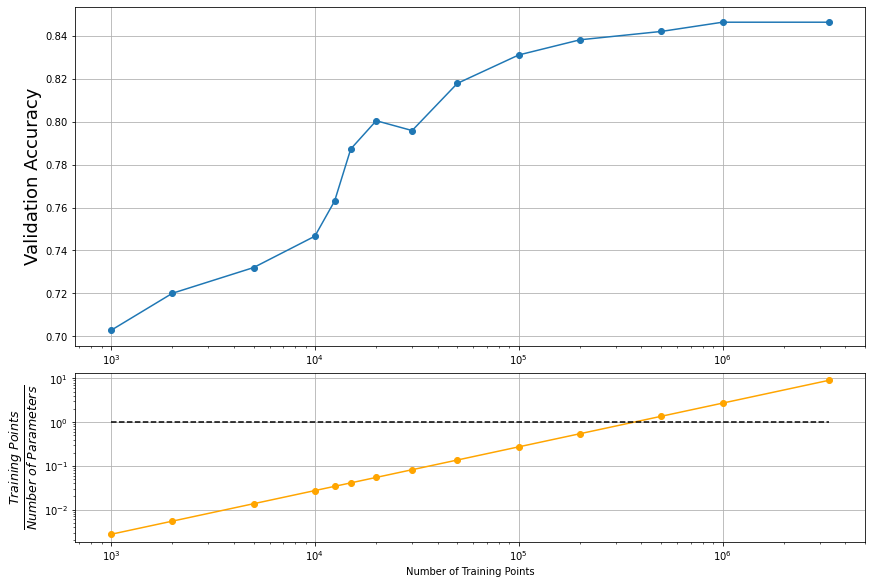

In [ ]:
#loss_ = [x[-1] for x in val_losses]
#acc_ = [x[-1] for x in val_accuracies]
acc_ = []
loss_ = []
for i in range(len(val_losses)):
    acc_idx = np.argmax(np.array(val_accuracies[i]))
    acc_.append(val_accuracies[i][acc_idx])
    loss_.append(val_losses[i][acc_idx])

trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
ratio = training_size / trainable_params


mosaic = """
    A
    A
    B
"""

fig = plt.figure(constrained_layout= True, figsize = (12,8))

ax_dict = fig.subplot_mosaic(mosaic)

ax_dict["A"].plot(training_size, acc_, "-o")
ax_dict["A"].set_xscale("log");
ax_dict["A"].set_ylabel("Validation Accuracy", size = 18);
ax_dict["A"].grid()

ax_dict["B"].plot(training_size, ratio, "-o", color = "orange")
ax_dict["B"].set_xscale("log");
ax_dict["B"].set_yscale("log");
ax_dict["B"].hlines(1, training_size[0], training_size[-1], linestyles = "dashed", color = "k")
ax_dict["B"].grid()
ax_dict["B"].set_ylabel(r"$\frac{Training\ Points}{Number\ of\ Parameters}$", size = 18);

plt.xlabel("Number of Training Points");


In [ ]:
import shap

In [ ]:
x_train_df = pd.DataFrame(x_train, columns = train_keys)
x_val_df = pd.DataFrame(x_val, columns = train_keys)

In [ ]:
f = lambda x: model.predict(x)
med = np.median(x_train, axis = 0).reshape((1,x_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(x_val_df.iloc[:1000])


In [ ]:
shap.plots.beeswarm(shap_values, max_display = 20)

In [126]:
train_keys

['ane',
 'ate',
 'autor',
 'machtor',
 'x',
 'zeff',
 'gammae',
 'q',
 'smag',
 'alpha',
 'ani1',
 'ati0',
 'normni1',
 'ti_te0',
 'lognustar']